In [1]:
# all imports
import pandas as pd
import numpy as np
import seaborn as sns
import time
import itertools
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import VarianceThreshold
from math import sqrt
import os.path

In [2]:
if os.path.isfile("bar_data.csv"):
    bar_data = pd.read_csv("bar_data.csv", index_col=0)
else:
    # Read data
    data = pd.read_csv("Training Data_PERPOC.csv")

    # Let's do the analysis for 'Bar'
    bar_data = data.loc[data['SEGMENT_POC'] == 'Bar'].copy()

    # Choose the right features
    features = ['YEAR', 'MONTH', 'DAY', 'COD_POC', 'SEGMENT_POC', 'DISCOUNT',
               'COUNTPOC', 'COD_PROD', 'FACTOR_HL', 'COD_ACOB', 'COD_COMBO',
               'COD_ACAO', 'WEEKOFMONTH', 'DAYOFWEEK', 'SAZ_MX', 'SAZ_DWX', 'SAZ_WMX',
               'POL_PTR', 'VOLPRODDAY', 'SUMMER', 'TEMPMAX', 'TEMPMIN', 'TEMPAVG',
               'HUMAVG', 'PRECIP', 'TEMPMAX_D+1', 'TEMPMAX_D-1', 'TEMPMAX_D+2',
               'TEMPMAX_D-2', 'TEMPMAX_D+3', 'TEMPMAX_D-3', 'TEMPMIN_D+1',
               'TEMPMIN_D-1', 'TEMPMIN_D+2', 'TEMPMIN_D-2', 'TEMPMIN_D+3',
               'TEMPMIN_D-3', 'TEMPAVG_D+1', 'TEMPAVG_D-1', 'TEMPAVG_D+2',
               'TEMPAVG_D-2', 'TEMPAVG_D+3', 'TEMPAVG_D-3', 'HUMAVG_D+1', 'HUMAVG_D-1',
               'HUMAVG_D+2', 'HUMAVG_D-2', 'HUMAVG_D+3', 'HUMAVG_D-3', 'PRECIP_D+1',
               'PRECIP_D-1', 'PRECIP_D+2', 'PRECIP_D-2', 'PRECIP_D+3', 'PRECIP_D-3',
               'SPECIAL_DATE', 'SPECIAL_DATE_D+1', 'SPECIAL_DATE_D-1',
               'SPECIAL_DATE_D+2', 'SPECIAL_DATE_D-2', 'SPECIAL_DATE_D+3',
               'SPECIAL_DATE_D-3', 'ICC', 'ICEA', 'INEC', 'INPC', 'INPC_AB', 'IPCA',
               'IPCA_AB', 'AVERAGEYIELD', 'SELIC_MONTH', 'UNEMPLOYMENTRATE', 'ICC_m-1',
               'ICEA_m-1', 'INEC_m-1', 'INPC_m-1', 'INPC_AB_m-1', 'IPCA_m-1',
               'IPCA_AB_m-1', 'AVERAGEYIELD_m-1', 'SELIC_MONTH_m-1',
               'UNEMPLOYMENTRATE_m-1', 'REPASSE', 'REPASSE+1', 'REPASSE-1']

    # Create a `DATE` column
    bar_data.insert(0, 'DATE', pd.to_datetime(bar_data[['YEAR', 'MONTH', 'DAY']]))

    # Create a `PTR` column, which takes into account the discount
    bar_data["PTR"] = bar_data["POL_PTR"] * (1 + bar_data["DISCOUNT"])

    # Sort the data set on the basis of time
    bar_data.sort_values(['YEAR', 'MONTH', 'DAY'], ascending=[True, True, True], inplace=True)

    # Create `MONTH` dummies
    bar_data = pd.concat([bar_data, pd.get_dummies(bar_data["MONTH"], prefix="MONTH")], axis=1)

    # Create `WEEK` dummies
    bar_data = pd.concat([bar_data, pd.get_dummies(bar_data["WEEKOFMONTH"], prefix="WEEK")], axis=1)

    # Create `DAYOFWEEK` dummies
    bar_data = pd.concat([bar_data, pd.get_dummies(bar_data["DAYOFWEEK"], prefix="DAYOFWEEK")], axis=1)

    # Create `NEARWEEKEND` dummy
    bar_data["NEARWEEKEND"] = bar_data["DAYOFWEEK_0"] | bar_data["DAYOFWEEK_6"] | bar_data["DAYOFWEEK_5"] | bar_data["DAYOFWEEK_4"]

    # Create `VOLPRODDAYWEEKSKU` across all PoCs
    vol_sku_week = bar_data.groupby(["MONTH", "WEEKOFMONTH", "COD_PROD"])["VOLPRODDAY"].agg('sum').reset_index()
    bar_data = bar_data.merge(right=vol_sku_week, how="left", on=["MONTH", "WEEKOFMONTH", "COD_PROD"], suffixes=["", "WEEKSKU"])

    # Create `VOLPRODDAYWEEK` for each PoC
    vol_sku_week = bar_data.groupby(["MONTH", "WEEKOFMONTH", "COD_POC"])["VOLPRODDAY"].agg('sum').reset_index()
    bar_data = bar_data.merge(right=vol_sku_week, how="left", on=["MONTH", "WEEKOFMONTH", "COD_POC"], suffixes=["", "WEEK"])

    # Perform log transforms for the volumes
    bar_data["LOG_VOLPRODDAY"] = np.log(bar_data["VOLPRODDAY"])
    bar_data["LOG_VOLPRODDAYWEEK"] = np.log(bar_data["VOLPRODDAYWEEK"])
    bar_data["LOG_VOLPRODDAYWEEKSKU"] = np.log(bar_data["VOLPRODDAYWEEKSKU"])

    # Perform log tranform for PTR
    bar_data["LOG_PTR"] = np.log(bar_data["PTR"])
    bar_data["LOG_POL_PTR"] = np.log(bar_data["POL_PTR"])

    # Create `DAYSINMONTH`
    bar_data["DAYSINMONTH"] = np.where(bar_data["MONTH"].isin([1, 3, 5, 7, 8, 10, 12]), 31, 30)
    bar_data["DAYSINMONTH"] = np.where(bar_data["MONTH"] == 2, 28, bar_data["DAYSINMONTH"])

    # Create a `POC_STOCK` column for each PoC
    # Get the assumed mean daily sales, when I assume every month, `total sales` = `total purchase`
    monthly_sales = bar_data.groupby(["YEAR", "MONTH", "COD_POC"])["VOLPRODDAY"].agg('sum').reset_index()
    bar_data = bar_data.merge(right=monthly_sales, how="left", on=["YEAR", "MONTH", "COD_POC"], suffixes=["", "_MEAN"])
    bar_data["VOLPRODDAY_MEAN"] /= bar_data["DAYSINMONTH"]

    # Get the `SALESTODATE`, which is according to our "monthly" assumption
    bar_data["SALESTODATE"] = bar_data["VOLPRODDAY_MEAN"] * bar_data["DAY"]

    # Get the `PURCHASETODATE`
    daily_purchase = bar_data.groupby(["YEAR", "MONTH", "DAY", "COD_POC"])["VOLPRODDAY"].agg('sum').reset_index()
    daily_purchase["PURCHASETODATE"] = daily_purchase.groupby(["YEAR", "MONTH", "COD_POC"])["VOLPRODDAY"].apply(lambda x: x.cumsum()).values
    daily_purchase["PURCHASETODATE"] = daily_purchase.groupby(["COD_POC"])["PURCHASETODATE"].apply(lambda x: x.shift(1))
    daily_purchase = daily_purchase.sort_values(["COD_POC", "YEAR", "MONTH", "DAY"]).reset_index()

    # Set the first entry in `PURCHASETODATE` for every month to 0
    for i in range(1, daily_purchase.shape[0]):
        if i == 1:
            daily_purchase.loc[i - 1, "PURCHASETODATE"] = 0

        if ((daily_purchase["MONTH"][i - 1] != daily_purchase["MONTH"][i]) or 
            (daily_purchase["COD_POC"][i - 1] != daily_purchase["COD_POC"][i])):
            daily_purchase.loc[i, "PURCHASETODATE"] = 0

    # Merge to POC data
    bar_data = bar_data.merge(right=daily_purchase, how="left", on=["YEAR", "MONTH", "DAY", "COD_POC"], suffixes=["", "_DAILY"])

    # Create the `POC_STOCK` column
    bar_data["POC_STOCK"] = bar_data["PURCHASETODATE"] - bar_data["SALESTODATE"]
    
    # Save the bar_data for future use
    bar_data.to_csv("bar_data.csv")

In [6]:
def get_training_set():
    
    features = [
                 # Engineered features
                 "POC_STOCK",
                 "LOG_PTR",
                 # "LOG_POL_PTR",
                 'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_11', 'MONTH_12',
                 "WEEK_1", "WEEK_2", "WEEK_3", "WEEK_4", "WEEK_5",
                 "DAYOFWEEK_0", "DAYOFWEEK_1", "DAYOFWEEK_2", "DAYOFWEEK_3", "DAYOFWEEK_4", "DAYOFWEEK_5",
                 "NEARWEEKEND",
                 "LOG_VOLPRODDAYWEEK",
                 "LOG_VOLPRODDAYWEEKSKU",

                 # All features which were already present   
                 'COD_POC', 
                 # 'DISCOUNT',
                 'COUNTPOC', 
                 # 'COD_PROD', 
                 'FACTOR_HL', 'COD_ACOB', 'COD_COMBO',
                 'COD_ACAO', 
                 # 'WEEKOFMONTH', 
                 # 'DAYOFWEEK', 
                 'SAZ_MX', 'SAZ_DWX', 'SAZ_WMX',
                 # 'POL_PTR', 
                 'SUMMER', 'TEMPMAX', 'TEMPMIN', 'TEMPAVG',
                 'HUMAVG', 'PRECIP', 
                 #'TEMPMAX_D+1', 'TEMPMAX_D-1', 'TEMPMAX_D+2',
                 #'TEMPMAX_D-2', 
                 #'TEMPMAX_D+3', 'TEMPMAX_D-3', 'TEMPMIN_D+1',
                 #'TEMPMIN_D-1', 'TEMPMIN_D+2', 'TEMPMIN_D-2', 'TEMPMIN_D+3',
                 #'TEMPMIN_D-3', 'TEMPAVG_D+1', 'TEMPAVG_D-1', 'TEMPAVG_D+2',
                 #'TEMPAVG_D-2', 'TEMPAVG_D+3', 'TEMPAVG_D-3', 'HUMAVG_D+1', 'HUMAVG_D-1',
                 #'HUMAVG_D+2', 'HUMAVG_D-2', 'HUMAVG_D+3', 'HUMAVG_D-3', 'PRECIP_D+1',
                 #'PRECIP_D-1', 'PRECIP_D+2', 'PRECIP_D-2', 'PRECIP_D+3', 'PRECIP_D-3',
                 'SPECIAL_DATE', 'SPECIAL_DATE_D+1', 'SPECIAL_DATE_D-1',
                 'SPECIAL_DATE_D+2', 'SPECIAL_DATE_D-2', 'SPECIAL_DATE_D+3',
                 'SPECIAL_DATE_D-3', 'ICC', 'ICEA', 'INEC', 'INPC', 'INPC_AB', 'IPCA',
                 'IPCA_AB', 'AVERAGEYIELD', 'SELIC_MONTH', 'UNEMPLOYMENTRATE', 'ICC_m-1',
                 'ICEA_m-1', 'INEC_m-1', 'INPC_m-1', 'INPC_AB_m-1', 'IPCA_m-1',
                 'IPCA_AB_m-1', 'AVERAGEYIELD_m-1', 'SELIC_MONTH_m-1',
                 'UNEMPLOYMENTRATE_m-1', 

                 'REPASSE', 'REPASSE+1', 'REPASSE-1'
               ]
    
    model_data = bar_data[bar_data["COD_PROD"] == cod_prod]

    X = model_data[features]
    # Remove features which have low variance - using Variance Thresholding
    selector = VarianceThreshold(threshold=1e-03)
    selector.fit(X)
    X = X.loc[:, selector.get_support()]
    y = model_data["LOG_VOLPRODDAY"]

    return (X, y)


def model_selection(X, y):
    # Best Subset Selection &
    # Forward & Backward Stepwise Selection
    # source = "http://www.science.smith.edu/~jcrouser/SDS293/labs/2016/lab8/Lab%208%20-%20Subset%20Selection%20in%20Python.pdf"

    def process_subset(feature_set):
        # Fit model on feature set
        X_data = X[list(feature_set)].copy()
        X_data = sm.add_constant(X_data)
        model = sm.OLS(y, X_data)
        results = model.fit()
        # rss = ((results.predict(X[list(feature_set)]) - y) ** 2).sum()
        return {"model": results, "rsquared_adj": results.rsquared_adj}


    def get_best(k):
        tic = time.time()
        results = []
        for combo in itertools.combinations(X.columns, k):
            results.append(process_subset(list(combo)))
        models = pd.DataFrame(results)
        best_model = models.loc[models["rsquared_adj"].idxmax()]
        toc = time.time()
        print("Processed", models.shape[0], "models on", k + 1, "predictors in", toc - tic, "seconds.")
        return best_model


    def forward(predictors):
        remaining_predictors = [p for p in X.columns if p not in predictors]
        tic = time.time()
        results = []
        for p in remaining_predictors:
            results.append(process_subset(predictors + [p]))
        models = pd.DataFrame(results)
        best_model = models.loc[models["rsquared_adj"].idxmax()]
        toc = time.time()
        print("Processed", models.shape[0], "models on", len(predictors) + 1, "predictors in", toc - tic, "seconds.")
        return best_model


    def backward(predictors):
        tic = time.time()
        results = []
        for combo in itertools.combinations(predictors, len(predictors) - 1):
            results.append(process_subset(combo))
        models = pd.DataFrame(results)
        best_model = models.loc[models["rsquared_adj"].idxmax()]
        toc = time.time()
        print("Processed", models.shape[0], "models on", len(predictors) - 1, "predictors in", toc - tic, "seconds.")
        return best_model


    def forward_stepwise_selection():
        models = pd.DataFrame(columns=["rsquared_adj", "model"])
        tic = time.time()
        predictors = []
        for i in range(1, len(X.columns) + 1):
            models.loc[i] = forward(predictors)
            predictors = models.loc[i]["model"].model.exog_names.copy()
            predictors.remove("const")
        toc = time.time()
        print("Total elapsed time:", toc - tic, "seconds.")
        return models


    def backward_stepwise_selection():
        models = pd.DataFrame(columns=["rsquared_adj", "model"], index=range(1, len(X.columns)))
        tic = time.time()
        predictors = X.columns
        while len(predictors) > 1:
            models.loc[len(predictors) - 1] = backward(predictors)
            predictors = models.loc[len(predictors) - 1]["model"].model.exog_names.copy()
            predictors.remove("const")
        toc = time.time()
        print("Total elapsed time:", toc - tic, "seconds.")
        return models


    def best_subset_selection(till):
        models = pd.DataFrame(columns=["rsquared_adj", "model"])
        tic = time.time()
        for i in range(1, till + 1):
            models.loc[i] = get_best(i)
        toc = time.time()
        print("Total elapsed time:", toc - tic, "seconds.")
        return models


    models_forward = forward_stepwise_selection()
    models_backward = backward_stepwise_selection()

    # Find the `best` models, on basis of ajusted R squared
    k_forward = models_forward.apply(lambda row: row[1].rsquared_adj, axis=1).idxmax()
    k_backward = models_backward.apply(lambda row: row[1].rsquared_adj, axis=1).idxmax()
    best_model_forward = models_forward.loc[k_forward, "model"]
    best_model_backward = models_backward.loc[k_backward, "model"]
    
    if best_model_forward.rsquared_adj > best_model_backward.rsquared_adj:
        best_model = best_model_forward
    else:
        best_model = best_model_backward

    return best_model


def iterative_feature_elimination(X, y, features, threshold_pvalue=0.10):
    iteration = 0
    while True:

        print("Iteration: %d" % (iteration))
        iteration += 1
        
        if "const" in features:
            features.remove("const")
        X = X[features]

        # Run an OLS model
        X = sm.add_constant(X)
        model = sm.OLS(y, X)
        results = model.fit()
        
        print("Adjusted R squared is", results.rsquared_adj)
        
        max_pvalue = max(results.pvalues[results.pvalues.index != "const"])
        if max_pvalue <= threshold_pvalue:
            print(results.summary())
            break

        feature_removed = results.pvalues.index[results.pvalues == max_pvalue].tolist()[0]
        features.remove(feature_removed)
        print("Feature removed is ", end="")
        print(feature_removed, end="\n\n")
        
    return results


def run_pipeline():
    
    # Make training data
    X, y = get_training_set()
    
    # Run model selection
    model = model_selection(X=X, y=y)
    
    # Save the model
    model.save("model_" + str(cod_prod) + ".pkl")
    
    # Run iterative feature elimination to eliminate non-significant features
    model_features = model.model.exog_names.copy()
    model = iterative_feature_elimination(X=X, y=y, threshold_pvalue=0.01, features=model_features)
    
    # Print the model summary
    print(model.summary())
    
    # Save the model
    model.save("model_" + str(cod_prod) + ".pkl")

In [ ]:
# Run for all SKUs in bar_data
for cod_prod in bar_data["COD_PROD"].unique():
    if (cod_prod == 9886) or (cod_prod == 90696):
        continue
    print("Running for Product " + str(cod_prod) + "...")
    model = run_pipeline()

Running for Product 90688...
Processed 67 models on 1 predictors in 0.6477012634277344 seconds.
Processed 66 models on 2 predictors in 1.0968632698059082 seconds.
Processed 65 models on 3 predictors in 1.1336605548858643 seconds.
Processed 64 models on 4 predictors in 1.4360787868499756 seconds.
Processed 63 models on 5 predictors in 1.847184419631958 seconds.
Processed 62 models on 6 predictors in 2.1727705001831055 seconds.
Processed 61 models on 7 predictors in 2.2470357418060303 seconds.
Processed 60 models on 8 predictors in 2.3066322803497314 seconds.
Processed 59 models on 9 predictors in 2.4329633712768555 seconds.
Processed 58 models on 10 predictors in 2.6929402351379395 seconds.
Processed 57 models on 11 predictors in 3.6672215461730957 seconds.
Processed 56 models on 12 predictors in 4.084802865982056 seconds.
Processed 55 models on 13 predictors in 3.856738805770874 seconds.
Processed 54 models on 14 predictors in 4.840362548828125 seconds.
Processed 53 models on 15 predic

Processed 13 models on 12 predictors in 0.8978168964385986 seconds.
Processed 12 models on 11 predictors in 0.8139457702636719 seconds.
Processed 11 models on 10 predictors in 0.543609619140625 seconds.
Processed 10 models on 9 predictors in 0.525956392288208 seconds.
Processed 9 models on 8 predictors in 0.32740330696105957 seconds.
Processed 8 models on 7 predictors in 0.2519702911376953 seconds.
Processed 7 models on 6 predictors in 0.27625107765197754 seconds.
Processed 6 models on 5 predictors in 0.13638544082641602 seconds.
Processed 5 models on 4 predictors in 0.09655570983886719 seconds.
Processed 4 models on 3 predictors in 0.06160759925842285 seconds.
Processed 3 models on 2 predictors in 0.059203147888183594 seconds.
Processed 2 models on 1 predictors in 0.03617143630981445 seconds.
Total elapsed time: 929.6094706058502 seconds.
Iteration: 0
Adjusted R squared is 0.2126559455521596
Feature removed is WEEK_1

Iteration: 1
Adjusted R squared is 0.21266947100849964
Feature remo

Processed 67 models on 1 predictors in 0.8235824108123779 seconds.
Processed 66 models on 2 predictors in 1.2520246505737305 seconds.
Processed 65 models on 3 predictors in 1.5628955364227295 seconds.
Processed 64 models on 4 predictors in 1.8362085819244385 seconds.
Processed 63 models on 5 predictors in 2.23687744140625 seconds.
Processed 62 models on 6 predictors in 3.1845924854278564 seconds.
Processed 61 models on 7 predictors in 3.173595905303955 seconds.
Processed 60 models on 8 predictors in 3.4728381633758545 seconds.
Processed 59 models on 9 predictors in 4.143113136291504 seconds.
Processed 58 models on 10 predictors in 4.378921270370483 seconds.
Processed 57 models on 11 predictors in 4.771786451339722 seconds.
Processed 56 models on 12 predictors in 5.083663702011108 seconds.
Processed 55 models on 13 predictors in 4.735735177993774 seconds.
Processed 54 models on 14 predictors in 6.399083375930786 seconds.
Processed 53 models on 15 predictors in 6.550716400146484 seconds.

Iteration: 0
Adjusted R squared is 0.3325318644295171
Feature removed is AVERAGEYIELD_m-1

Iteration: 1
Adjusted R squared is 0.33253166441833815
Feature removed is SAZ_DWX

Iteration: 2
Adjusted R squared is 0.3325320592094584
Feature removed is SPECIAL_DATE_D+2

Iteration: 3
Adjusted R squared is 0.3325291847191447
Feature removed is SPECIAL_DATE_D+1

Iteration: 4
Adjusted R squared is 0.3325247768485129
Feature removed is DAYOFWEEK_5

Iteration: 5
Adjusted R squared is 0.33251096483191944
Feature removed is SPECIAL_DATE

Iteration: 6
Adjusted R squared is 0.33249335696742355
Feature removed is SAZ_MX

Iteration: 7
Adjusted R squared is 0.3324664205497435
Feature removed is ICC_m-1

Iteration: 8
Adjusted R squared is 0.33244837516755554
Feature removed is TEMPMIN

Iteration: 9
Adjusted R squared is 0.33240603502406973
Feature removed is TEMPMAX

Iteration: 10
Adjusted R squared is 0.332362299448546
                            OLS Regression Results                            
Dep. Va

Processed 67 models on 1 predictors in 0.9563093185424805 seconds.
Processed 66 models on 2 predictors in 1.3452658653259277 seconds.
Processed 65 models on 3 predictors in 1.8849122524261475 seconds.
Processed 64 models on 4 predictors in 2.1754508018493652 seconds.
Processed 63 models on 5 predictors in 2.8293800354003906 seconds.
Processed 62 models on 6 predictors in 2.986443042755127 seconds.
Processed 61 models on 7 predictors in 3.594505548477173 seconds.
Processed 60 models on 8 predictors in 4.207286596298218 seconds.
Processed 59 models on 9 predictors in 4.174593210220337 seconds.
Processed 58 models on 10 predictors in 5.032221794128418 seconds.
Processed 57 models on 11 predictors in 5.208092927932739 seconds.
Processed 56 models on 12 predictors in 6.2238078117370605 seconds.
Processed 55 models on 13 predictors in 6.961621522903442 seconds.
Processed 54 models on 14 predictors in 8.182640075683594 seconds.
Processed 53 models on 15 predictors in 7.839099168777466 seconds

Processed 12 models on 11 predictors in 1.2234399318695068 seconds.
Processed 11 models on 10 predictors in 0.8836181163787842 seconds.
Processed 10 models on 9 predictors in 0.6604115962982178 seconds.
Processed 9 models on 8 predictors in 0.5291600227355957 seconds.
Processed 8 models on 7 predictors in 0.40630221366882324 seconds.
Processed 7 models on 6 predictors in 0.3122894763946533 seconds.
Processed 6 models on 5 predictors in 0.21570563316345215 seconds.
Processed 5 models on 4 predictors in 0.14719557762145996 seconds.
Processed 4 models on 3 predictors in 0.09305930137634277 seconds.
Processed 3 models on 2 predictors in 0.055617570877075195 seconds.
Processed 2 models on 1 predictors in 0.026623249053955078 seconds.
Total elapsed time: 1423.9186980724335 seconds.
Iteration: 0
Adjusted R squared is 0.35440938625994256
Feature removed is NEARWEEKEND

Iteration: 1
Adjusted R squared is 0.35440938625994245
Feature removed is TEMPAVG

Iteration: 2
Adjusted R squared is 0.354407

Processed 67 models on 1 predictors in 1.325052261352539 seconds.
Processed 66 models on 2 predictors in 1.8315320014953613 seconds.
Processed 65 models on 3 predictors in 2.3282907009124756 seconds.
Processed 64 models on 4 predictors in 3.1618316173553467 seconds.
Processed 63 models on 5 predictors in 3.5763728618621826 seconds.
Processed 62 models on 6 predictors in 4.052763223648071 seconds.
Processed 61 models on 7 predictors in 5.013463020324707 seconds.
Processed 60 models on 8 predictors in 5.539824724197388 seconds.
Processed 59 models on 9 predictors in 5.910245418548584 seconds.
Processed 58 models on 10 predictors in 6.66363000869751 seconds.
Processed 57 models on 11 predictors in 7.329565048217773 seconds.
Processed 56 models on 12 predictors in 8.058206796646118 seconds.
Processed 55 models on 13 predictors in 8.657148838043213 seconds.
Processed 54 models on 14 predictors in 9.164616107940674 seconds.
Processed 53 models on 15 predictors in 10.0220627784729 seconds.
Pr

In [16]:
# See the results
for cod_prod in bar_data["COD_PROD"].unique():
    print("*" * 110, end="\n\n")
    print("For SKU", cod_prod, "in bar segment: \n\n")
    model = sm.load("model_" + str(cod_prod) + ".pkl")
    print(model.summary())

**************************************************************************************************************

For SKU 90696 in bar segment: 


                            OLS Regression Results                            
Dep. Variable:         LOG_VOLPRODDAY   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     793.0
Date:                Thu, 04 Oct 2018   Prob (F-statistic):               0.00
Time:                        19:28:10   Log-Likelihood:            -1.0498e+05
No. Observations:               84753   AIC:                         2.100e+05
Df Residuals:                   84725   BIC:                         2.103e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|

                            OLS Regression Results                            
Dep. Variable:         LOG_VOLPRODDAY   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     1659.
Date:                Thu, 04 Oct 2018   Prob (F-statistic):               0.00
Time:                        19:28:10   Log-Likelihood:            -1.1995e+05
No. Observations:              117234   AIC:                         2.400e+05
Df Residuals:                  117201   BIC:                         2.403e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -29.00

/py3env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


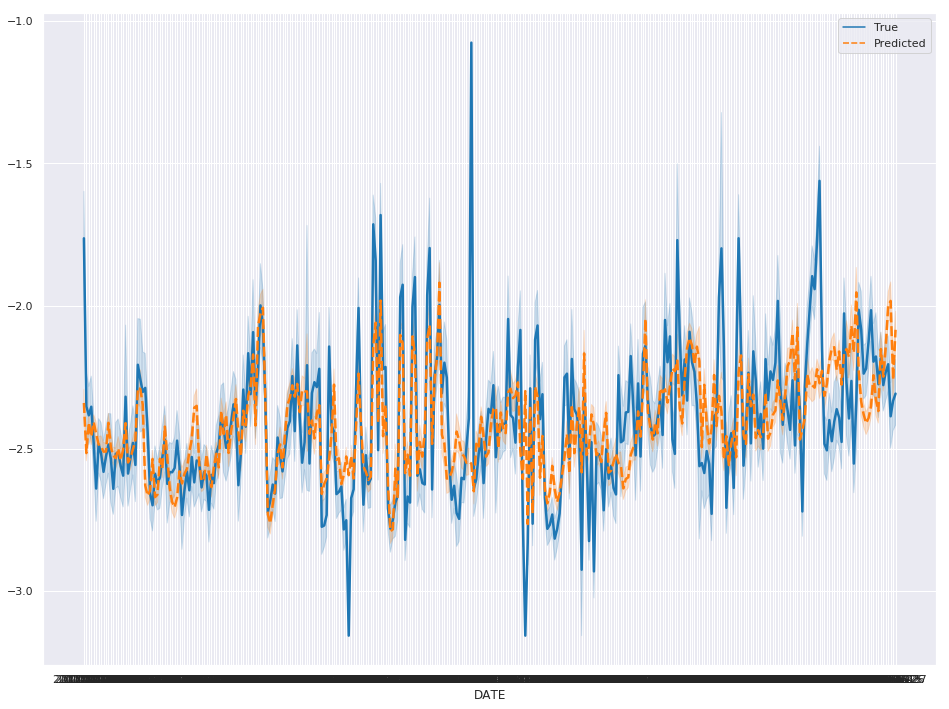

In [10]:
# Check the fit on the training set
dates = model_data['DATE']
X = model_data.copy()
X = sm.add_constant(X, has_constant=True)
X = X[model.model.exog_names]
values = pd.concat([y, pd.Series(model.predict(X), index=y.index)], axis=1).values
data = pd.DataFrame(values, dates, columns=["True", "Predicted"])
sns.set(rc={'figure.figsize':(16, 12)}) # (11.7,8.27) before
sns.lineplot(data=data, palette="tab10", linewidth=2.5)